# Experiment A: NormAE vs ScGen

This notebook is meant to compare NormAE and ScGen.


In [1]:
def show_time(process, time_start, time_end):
    time_took = "\n" + str(process) + " finished in "
    if (round((time_end-time_start)/60, 1) < 1):
      time_took = time_took + str(round((time_end-time_start), 1)) + " seconds "
    elif (round((time_end-time_start)/60/60, 1) < 1):
      time_took = time_took + str(round((time_end-time_start)/60, 1)) + " minutes "
    else:
      time_took = time_took + str(round((time_end-time_start)/60/60, 1)) + " hours "
    time_took = time_took + "(wall clock).\n\n"
    return time_took
########## end of show_time function

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys, time # import modules
import torch

print (f"cwd:{os.getcwd()}")
os.chdir("/content")
print (f"cwd:{os.getcwd()}")

start_time = time.time()

!rm -rf DL-Batch-Correction/ # import module}
!git clone https://github.com/PNNL-Comp-Mass-Spec/DL-Batch-Correction
sys.path.insert(1, os.path.abspath('DL-Batch-Correction/'))

end_time = time.time()
print_this = show_time("git repo clone", start_time, end_time)
print (print_this)

os.chdir("DL-Batch-Correction")
print (f"cwd:{os.getcwd()}")

#!git checkout master_optuna

cwd:/content
cwd:/content
Cloning into 'DL-Batch-Correction'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 185 (delta 70), reused 101 (delta 41), pack-reused 49
Receiving objects: 100% (185/185), 49.48 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (92/92), done.

git repo clone finished in 4.9 seconds (wall clock).


cwd:/content/DL-Batch-Correction


In [3]:
try:
  import optuna
except:
  !pip install optuna
  import optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 67.1 MB/s 
     |████████████████████████████████| 80 kB 12.2 MB/s 
     |████████████████████████████████| 75 kB 6.1 MB/s 
     |████████████████████████████████| 144 kB 72.2 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
     |████████████████████████████████| 111 kB 72.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=85c0f220cf46b5d56e16499fc87a7c3ef0597a4dc1baa7bf867e0dad49f7c4eb
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## Exp 1B. NormAE vs ScGen on Emory data

### Load data

In [4]:
# just drag synth_data.txt/synth_labels.txt to uppermost folder at left of this colab
print (f"cwd:{os.getcwd()}")

from load_data import load_labeled_data
path_to_data   = './emory_data.txt'
path_to_labels = './emory_labels.txt'
train_data, test_data, metadata = load_labeled_data(path_to_data, path_to_labels)
_, _, n_features, n_batches, _, _ = metadata.values()
print (f"n_features:{n_features}, n_batches:{n_batches}")
# For emory dataset, this should be 
# n_features:1811, n_batches:50

cwd:/content/DL-Batch-Correction
n_features:363, n_batches:50


### Train both models

In [8]:
n_latent   = 50 # model parameters
enc_width  = 500
disc_width = 50
max_epochs = 3 #10000 # 3
batch_size = 32
normae_schedule = [100, 0, 200, 1]
early_stopping = True
check_every    = 200 #200 was definitely not enough for 500 features of emory dataset (doonam, 11/3/2021)
plot_metrics   = True
autoencoder_learning_rate = 5e-5
discriminator_learning_rate = 1e-2

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
def try_many(trial):
    print ("\n")
    n_latent = trial.suggest_int('n_latent', 2, 1000)
    enc_width = trial.suggest_int('enc_width', 2, 1000)
    disc_width = trial.suggest_int('disc_width', 2, 1000)
    batch_size = trial.suggest_int('batch_size', 2, 32)
    
    normae = NormAE(n_features, n_batches, n_latent,
                encoder_width       = enc_width,
                discriminator_width = disc_width)
    normae = normae.to(device)
    
    normae.train(train_data, device, max_epochs, batch_size,
                lambda_schedule = normae_schedule,
                test_data = test_data,
                autoencoder_learning_rate = autoencoder_learning_rate,
                discriminator_learning_rate = discriminator_learning_rate,
                early_stopping = True,
                check_every = check_every)
    
    return normae.metrics[-1][3]

from models import NormAE
study = optuna.create_study()

start_time = time.time()
study.optimize(try_many, n_trials=2)
end_time = time.time()
print_this = show_time("optimize", start_time, end_time)
print (print_this)

study.best_params

fig = optuna.visualization.plot_contour(study, params=['n_latent', 'enc_width', 'disc_width', 'batch_size'])
fig.show()

[I 2021-11-03 22:01:30,507] A new study created in memory with name: no-name-1f4c6b6d-f02d-4652-9c54-4be70d1615c1


TrainLoss: 27.859 (RecLoss=27.859, DiscLoss=-2.102) | TestLoss: 0.670 (RecLoss=0.670, DiscLoss=-0.060): 100%|██████████| 3/3 [00:00<00:00, 12.64it/s]
[I 2021-11-03 22:01:30,772] Trial 0 finished with value: 0.6698417067527771 and parameters: {'n_latent': 600, 'enc_width': 520, 'disc_width': 248, 'batch_size': 12}. Best is trial 0 with value: 0.6698417067527771.


TrainLoss: 16.136 (RecLoss=16.136, DiscLoss=-1.344) | TestLoss: 0.638 (RecLoss=0.638, DiscLoss=-0.067): 100%|██████████| 3/3 [00:00<00:00, 19.96it/s]
[I 2021-11-03 22:01:30,975] Trial 1 finished with value: 0.6378722190856934 and parameters: {'n_latent': 980, 'enc_width': 872, 'disc_width': 748, 'batch_size': 20}. Best is trial 1 with value: 0.6378722190856934.



optimize finished in 0.5 seconds (wall clock).




**Run NormAE!**

Initializing models... 

TrainLoss: 1.073 (RecLoss=1.019, DiscLoss=-0.054) | TestLoss: 0.157 (RecLoss=0.167, DiscLoss=0.010):  38%|███▊      | 3801/10000 [15:13<24:49,  4.16it/s]


Early stopping after 3800 epochs

done!
Training NormAE... finished in 15.2 minutes (wall clock).


Plotting loss metrics...
normae.plot_metrics


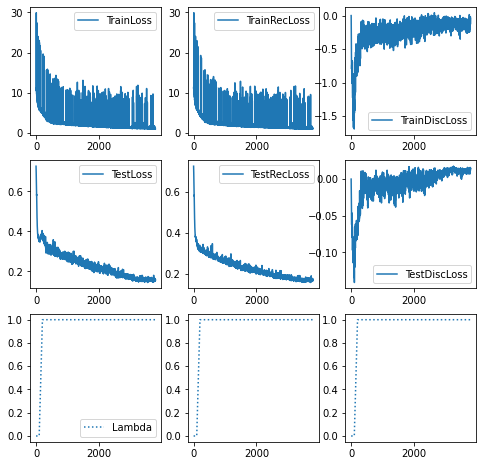

In [ ]:
from models import NormAE
print('Initializing models... ', end='')
'''n_latent   = 106
enc_width  = 297
disc_width = 993
batch_size = 5'''

n_latent   = 50 # model parameters
enc_width  = 500
disc_width = 50
max_epochs = 10000 # 3
batch_size = 32
normae_schedule = [100, 0, 200, 1]
early_stopping = True
check_every    = 200 #200 was definitely not enough for 500 features of emory dataset (doonam, 11/3/2021)
plot_metrics   = True
autoencoder_learning_rate = 5e-5
discriminator_learning_rate = 1e-2

normae = NormAE(n_features, n_batches, n_latent,
                encoder_width       = enc_width,
                discriminator_width = disc_width)
normae = normae.to(device)

start_time = time.time()

normae.train(train_data, device, max_epochs, batch_size,
            lambda_schedule = normae_schedule,
             test_data = test_data,
             autoencoder_learning_rate = autoencoder_learning_rate,
             discriminator_learning_rate = discriminator_learning_rate,
             early_stopping = True,
             check_every = check_every)
end_time = time.time()
print_this = show_time('done!\nTraining NormAE...', start_time, end_time)
print (print_this)

print('Plotting loss metrics...')
if plot_metrics:
  print ("normae.plot_metrics")
  normae.plot_metrics(normae_schedule)

type(datasets[key]):<class 'torch.Tensor'>
type(datasets):<class 'dict'>


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f04115aa3d0>,
      dtype=object)

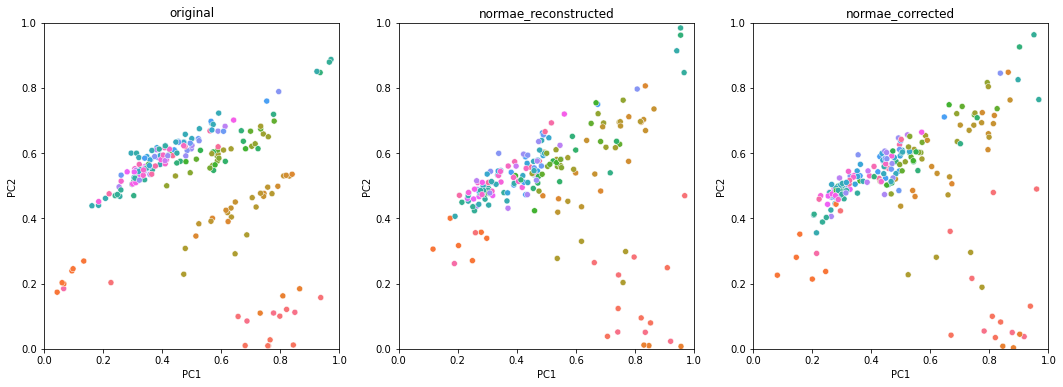

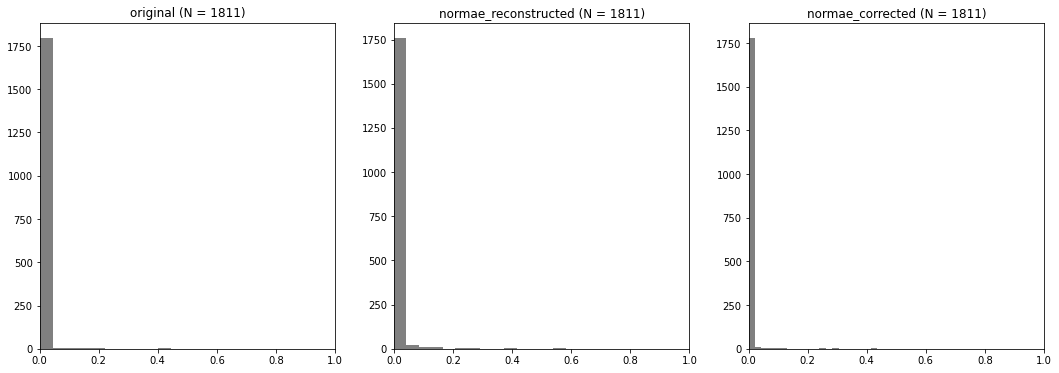

In [ ]:
from qcmetrics import plot_several_anova
from qcmetrics import plot_several_pca

x = test_data[:][0]
y = test_data[:][1]
datasets = {'original': x}
model_in = x.to(device), y.to(device)

x_rec_1, _, _, x_star_1 = normae.forward(device, model_in)

datasets['normae_reconstructed'] = x_rec_1
datasets['normae_corrected']     = x_star_1

print (f"type(datasets):{type(datasets)}")
#<class 'dict'>

print (f"type(datasets[key]):{type(datasets[key])}")
#<class 'torch.Tensor'>

for key in datasets.keys():
  datasets[key] = datasets[key].detach().cpu().numpy()

plot_several_pca(datasets, y)
plot_several_anova(datasets, y)

**Run scGen!**

In [ ]:
##@title
from models import NormAE
from models import scGen
print('Initializing models... ', end='')
normae = NormAE(n_features, n_batches, n_latent,
                encoder_width       = enc_width,
                discriminator_width = disc_width)
scgen = scGen(n_features, n_batches, n_latent,
              encoder_width = enc_width)
normae = normae.to(device)
scgen  = scgen.to(device)

start_time = time.time()
max_epochs=10000
normae.train(train_data, device, max_epochs, batch_size,
            lambda_schedule = normae_schedule,
             test_data = test_data,
             autoencoder_learning_rate = autoencoder_learning_rate,
             discriminator_learning_rate = discriminator_learning_rate,
             early_stopping = True,
             check_every = check_every)
#print('done!\nTraining NormAE...')
end_time = time.time()
print_this = show_time('done!\nTraining NormAE...', start_time, end_time)
print (print_this)


start_time = time.time()
print('Training scGen...')
max_epochs=200
scgen.train(train_data, device, max_epochs, batch_size,
            test_data = test_data,
             early_stopping = True,
            check_every = 20)
end_time = time.time()
print_this = show_time('Training scGen...', start_time, end_time)
print (print_this)

print('Plotting loss metrics...')
if plot_metrics:
  print ("normae.plot_metrics")
  normae.plot_metrics(normae_schedule)

if plot_metrics:
   print ("scgen.plot_metrics")
   scgen.plot_metrics()

### Plot metrics

In [ ]:
from qcmetrics import plot_several_anova
from qcmetrics import plot_several_pca

x = test_data[:][0]
y = test_data[:][1]
datasets = {'original': x}
model_in = x.to(device), y.to(device)

x_rec_1, _, _, x_star_1 = normae.forward(device, model_in)
x_rec_2, _,    x_star_2 = scgen.forward(device, model_in)

datasets['normae_reconstructed'] = x_rec_1
datasets['normae_corrected']     = x_star_1
datasets['scgen_reconstructed']  = x_rec_2
datasets['scgen_corrected']      = x_star_2

for key in datasets.keys():
  datasets[key] = datasets[key].detach().cpu().numpy()

plot_several_pca(datasets, y)
plot_several_anova(datasets, y)